## Fixed parameter search

This notebook is intendend to find the best matching values for fixed parameters to be used in the simulation.

These parameters include:
- Distribution of time between orders.
    - Probably exponential distribution, extension of Poisson dist
- Distribution of token size of trades
    - Possibly different for buy and sell orders
- Buy or Sell order
    - Some function of past X trades completed. This is undecided yet.

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy.stats import kstest, expon
from scipy.stats import halfgennorm, pareto
from fitter import Fitter, get_common_distributions, get_distributions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pair_list = [
            ("AGIX-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0xe45b4a84e0ad24b8617a489d743c52b84b7acebe", 40),
            ("HEX-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x55d5c232d921b9eaa6b37b5845e439acd04b4dba", 100),
            ("OPTIMUS-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x8de7a9540e0edb617d78ca5a7c6cc18295fd8bb9", 70),
            ("SHIB-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x811beed0119b4afce20d2583eb608c6f7af1954f", 50),
            ("SHIK-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x0b9f5cef1ee41f8cccaa8c3b4c922ab406c980cc", 60),
            ("BabyDoge-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0xc736ca3d9b1e90af4230bd8f9626528b3d4e0ee0", 180),
            ("FLOKI-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x231d9e7181e8479a8b40930961e93e7ed798542c", 180),
            ("INJ-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x1bdcebca3b93af70b58c41272aea2231754b23ca", 60),
            ("MBOX-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x8fa59693458289914db0097f5f366d771b7a7c3f", 90),
            ("VOLT-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x487bfe79c55ac32785c66774b597699e092d0cd9", 200)
            ]

In [13]:
def load_csv_to_df(file_path, verbose=False, name=""):
    # Load CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # If verbose mode is enabled, print the dataset name, number of rows, and some datetime information
    if verbose:
        #print(name)
        print("Number of rows:", len(df))
        print("Last datetime:", df.datetime.iloc[-2], )  # Assuming there is a "datetime" column in the DataFrame
        print("First datetime:", df.datetime.iloc[0])
        print("Time difference (in days):", datetime.strptime(df.datetime.iloc[0], '%Y-%m-%d %H:%M:%S') - datetime.strptime(df.datetime.iloc[-5], '%Y-%m-%d %H:%M:%S'))
        print()
    
    # Return the DataFrame
    return df

def set_index(df, info=False):
    # Convert 'datetime' column to datetime type and set it as the index
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    
    if info:
        # Print some information about the resulting DataFrame
        df.info()

In [40]:
##Part 1 - The time spacing
table_dists = []
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    #print(name)
    # if name == "FLOKI-WBNB":
    #     continue
    print(f"~~~---{name}---~~~")
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)


    #compute the spacing between variables
    spacing = np.diff(df.index).astype('timedelta64[s]').astype(int) *-1

    #Cropping data to 99th percentile
    percentile_99 = np.percentile(spacing, 99)
    spacing_99 = [val for val in spacing if val <= percentile_99]

    basic_expon = False
    if basic_expon:
        param = expon.fit(spacing_99)
        print(param)

        statistic, p_value = kstest(spacing_99, 'expon', args=param)

        # Print the p-value
        print("The p-value is:", p_value)

    fitter_dist_fitting = True #next to do -- put this to its own cell
    if fitter_dist_fitting:
        #dists = get_common_distributions()
        #dists.append('exponweib')
        #dists = get_distributions()
        # dists = ['gamma',
        #         'lognorm',
        #         "beta",
        #         "burr",
        #         "norm",
        #         "expon", 
        #         "exponnorm", 
        #         "exponpow",
        #          "exponweib",
        #          "truncexpon",
        #          "pareto",
        #          "cauchy",
        #          "gumbel_r",
        #          "laplace"]

        ###Candidate distributions selected based on running all dists on several tokens
        # d = get_common_distributions()
        # d.extend(['johnsonsb', 'fatiguelife', 'exponweib', 'gengamma', 'halfgennorm'])
        # d.extend(['pareto', 'expon', 'halflogistic', 'cauchy', 'moyal'])
        # d.extend(['fatiguelife', 'exponweib', 'gengamma', 'halfgennorm', 'lognorm'])
        # d.extend(['invgauss', 'betaprime', 'halfcauchy', 'fatiguelife', 'genextreme'])
        # d.extend(['invgauss', 'betaprime', 'halfcauchy', 'fatiguelife', 'genextreme'])
        # d.extend(['pareto', 'expon', 'cauchy', 'moyal', 'gumbel_r'])
        # d.extend(['f', 'kappa3', 'alpha', 'beta', 'bradford'])
        # d.extend(['expon', 'cauchy', 'laplace', 'gumbel_r', 'logistic'])
        # dists = list(set(d))

        #dists = ['halfgennorm']
        #dists = ['pareto']
        dists = ['expon']

        f = Fitter(spacing_99,
           distributions=dists)
        f.fit()
        
        try:
            print(f.get_best())     #here I end up. The goal is to estimate distributions from which draw times. 
                                    #heaving three is a good way I think. One of them will be halfgennorm with beta = 0.4
                                    #What to do next: check that the selected first dist will be ok if I set parameter beta fixed to 0.4, plot i histograms as random sample. Do the same for pareto. end expon                               
        except:
            pass                                    
        # print(f.summary())
        # plt.show()

        Nbest = 5
        ###Try to get x best dists
        names = f.df_errors.sort_values(
                    by="bic").index[0:Nbest].values
        
        #print(names)
        
        
    
        do_dist_table = False
        if do_dist_table:
            row = [name[:-5]]
            for element in dists:
                if element in names:
                    row.append(1)
                else:
                    row.append(" ")
            table_dists.append(row)
            #print(names)

        

        ##lets try three runs on the first token
        #run 1: ['johnsonsb', 'fatiguelife', 'exponweib', 'gengamma', 'halfgennorm'] (not restarted)
        #run 2: ['pareto', 'expon', 'halflogistic', 'cauchy', 'moyal'] (restarted)
        #run 3: ['fatiguelife', 'exponweib', 'gengamma', 'halfgennorm', 'lognorm'] (not restarted)
        #run 4: ['fatiguelife' 'exponweib' 'gengamma' 'halfgennorm' 'levy'] (restarted + bic selection)

        ##Two runs on OPTIMUS
        #run 1: ['invgauss', 'betaprime', 'halfcauchy', 'fatiguelife', 'genextreme'] (restarted)
        #run 2: ['invgauss', 'betaprime', 'halfcauchy', 'fatiguelife', 'genextreme'] (restarted)
        #run 3: ['pareto', 'expon', 'cauchy', 'moyal', 'gumbel_r'] (not restarted)

        ##Two runs at FLOKI
        #run 1: ['f', 'kappa3', 'alpha', 'beta', 'bradford'] (restarted)
        #run 2: ['expon', 'cauchy', 'laplace', 'gumbel_r', 'logistic'] (not restarted)

if do_dist_table:        
    table_dists = pd.DataFrame(table_dists)
    #table_dists.set_index(table_dists.iloc[:, 0], inplace=True)
    #table_dists.columns = ["Token"].extend(dists)
    colnames = list(["Token"])
    colnames.extend(dists)
    table_dists.columns = colnames
    #print(table_dists)
    #table_dists.to_csv(r"D:\Dokumenty\Vejška\Magisterské studium\DIPLOMKA\Tables\Timing_distributions_scores.csv", index=False)


    #once at home, try to run on all distributions, and set the max names to 10
    

~~~---AGIX-WETH---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 91.15it/s]


{'expon': {'loc': 0.0, 'scale': 398.22149302707135}}
~~~---HEX-WETH---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]


{'expon': {'loc': 0.0, 'scale': 95.83093899646055}}
~~~---OPTIMUS-WETH---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 52.78it/s]


{'expon': {'loc': 0.0, 'scale': 153.3993220338983}}
~~~---SHIB-WETH---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 58.98it/s]


{'expon': {'loc': 0.0, 'scale': 306.1414913957935}}
~~~---SHIK-WETH---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 83.56it/s]


{'expon': {'loc': 0.0, 'scale': 335.943754394188}}
~~~---BabyDoge-WBNB---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 28.65it/s]


{'expon': {'loc': 0.0, 'scale': 68.75762721148052}}
~~~---FLOKI-WBNB---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 100.27it/s]


{'expon': {'loc': 0.0, 'scale': 44.877010877891834}}
~~~---INJ-WBNB---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


{'expon': {'loc': 0.0, 'scale': 185.54828744123571}}
~~~---MBOX-WBNB---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 111.38it/s]


{'expon': {'loc': 0.0, 'scale': 103.46294594368786}}
~~~---VOLT-WBNB---~~~


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 91.15it/s]

{'expon': {'loc': 0.0, 'scale': 60.60467855940761}}


~~~---AGIX-WETH---~~~


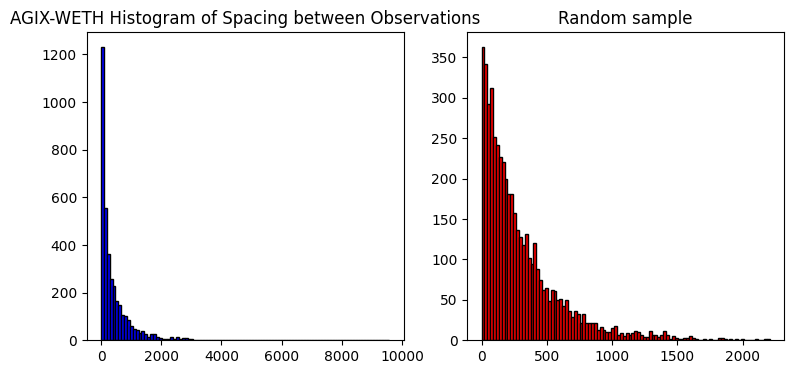

~~~---HEX-WETH---~~~


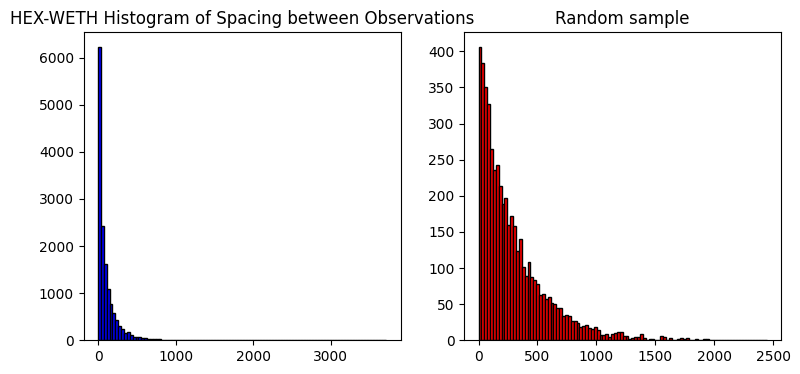

~~~---OPTIMUS-WETH---~~~


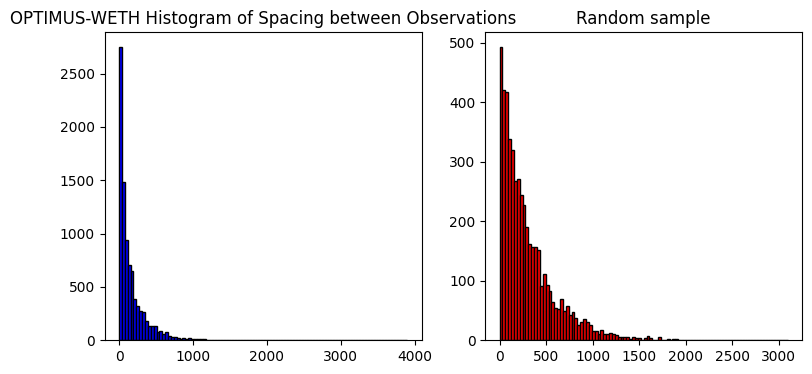

~~~---SHIB-WETH---~~~


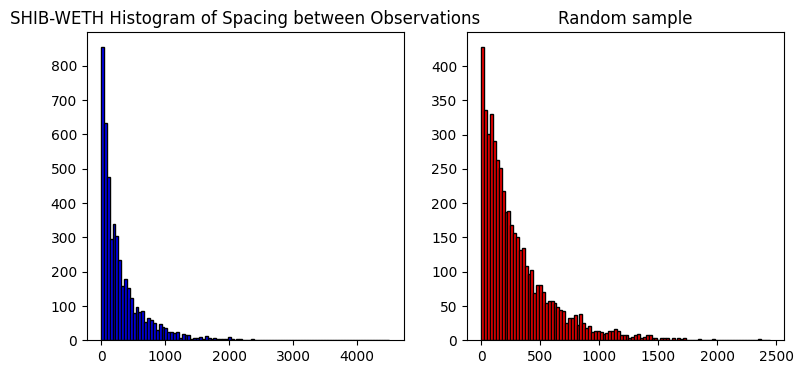

~~~---SHIK-WETH---~~~


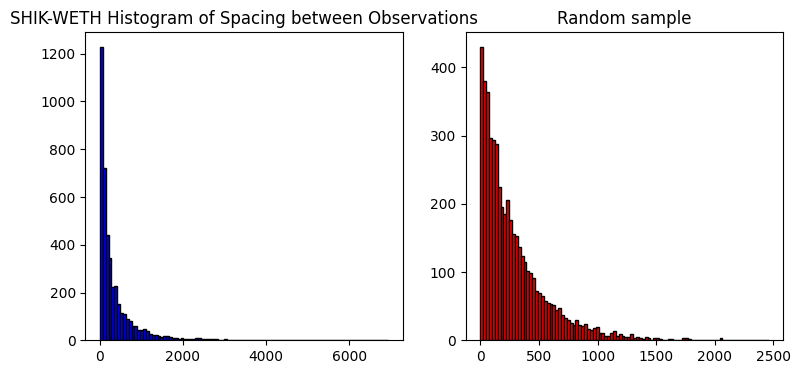

~~~---BabyDoge-WBNB---~~~


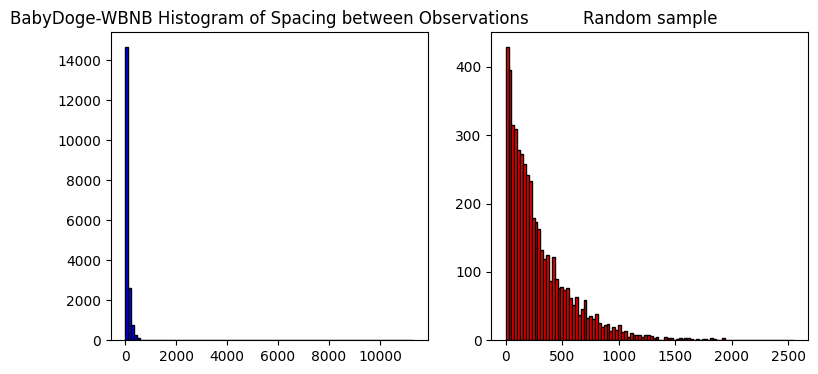

~~~---FLOKI-WBNB---~~~


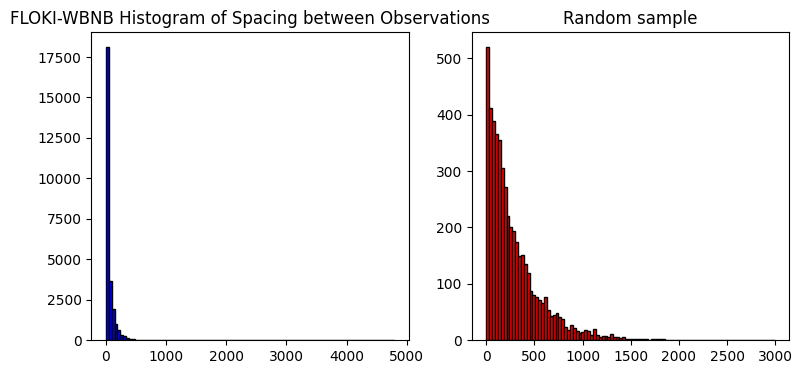

~~~---INJ-WBNB---~~~


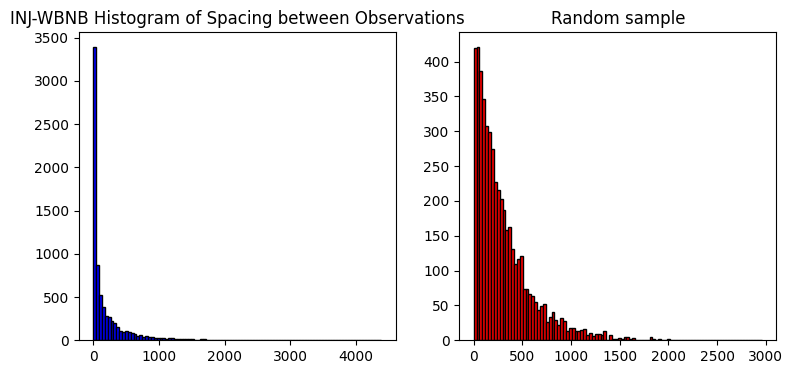

~~~---MBOX-WBNB---~~~


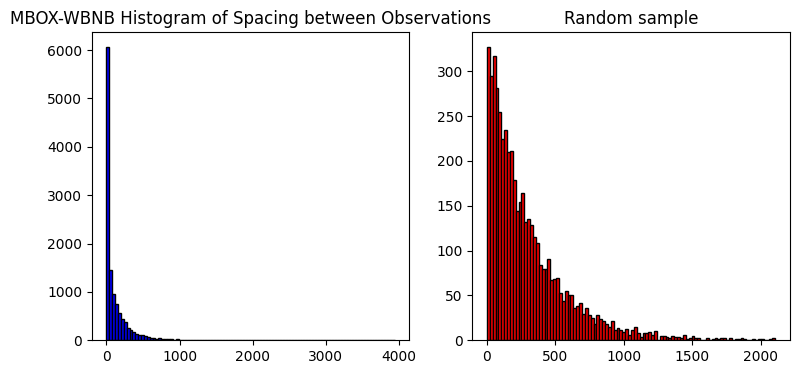

~~~---VOLT-WBNB---~~~


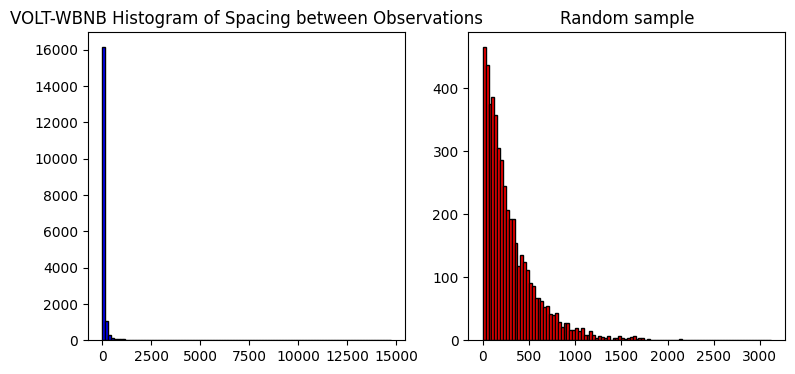

In [50]:
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    #print(name)
    # if name == "FLOKI-WBNB":
    #     continue
    print(f"~~~---{name}---~~~")
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)


    #compute the spacing between variables
    spacing = np.diff(df.index).astype('timedelta64[s]').astype(int) *-1

    #Cropping data to 99th percentile
    percentile_99 = np.percentile(spacing, 99)
    spacing_99 = [val for val in spacing if val <= percentile_99]


    #Try to compare data with random sample from the fitted distributions
    #r = halfgennorm.rvs(beta = 0.4, loc=0, scale=4, size=5000)#This is how to draw random sample from halfgennorm - this will be my setting number one, it fits many distributions well (only first parameter decides about shape of dist., seconf is always 0 and third about size)
    #r = pareto.rvs(b = 2.5, loc=-80, scale=80, size=5000) #This I guess will by my second distribution
    r = expon.rvs(loc = 0, scale=300, size = 5000) #And this could be the third one
    #
    #{'pareto': {'b': 6.793733998573082, 'loc': -400.09425046951173, 'scale': 400.0942504695117}
    #{'expon': {'loc': 0.0, 'scale': 306.1414913957935}}
    

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    axes[0].hist(spacing, bins=100, color='blue', edgecolor='black')
    axes[0].set_title(f'{name} Histogram of Spacing between Observations')

    axes[1].hist(r, bins=100, color='red', edgecolor='black')
    axes[1].set_title('Random sample')
    
    #plt.hist(spacing_99, bins=100, edgecolor='black')
    plt.show()

In [16]:
##lets try three runs on the first token
        #run 1: ['johnsonsb', 'fatiguelife', 'exponweib', 'gengamma', 'halfgennorm'] (not restarted)
        #run 2: ['pareto', 'expon', 'halflogistic', 'cauchy', 'moyal'] (restarted)
        #run 3: ['fatiguelife', 'exponweib', 'gengamma', 'halfgennorm', 'lognorm'] (not restarted)

        ##Two runs on OPTIMUS
        #run 1: ['invgauss', 'betaprime', 'halfcauchy', 'fatiguelife', 'genextreme'] (restarted)
        #run 2: ['invgauss', 'betaprime', 'halfcauchy', 'fatiguelife', 'genextreme'] (restarted)
        #run 3: ['pareto', 'expon', 'cauchy', 'moyal', 'gumbel_r'] (not restarted)

        ##Two runs at FLOKI
        #run 1: ['f', 'kappa3', 'alpha', 'beta', 'bradford'] (restarted)
        #run 2: ['expon', 'cauchy', 'laplace', 'gumbel_r', 'logistic'] (not restarted)
d = get_common_distributions()
d.extend(['johnsonsb', 'fatiguelife', 'exponweib', 'gengamma', 'halfgennorm'])
d.extend(['pareto', 'expon', 'halflogistic', 'cauchy', 'moyal'])
d.extend(['fatiguelife', 'exponweib', 'gengamma', 'halfgennorm', 'lognorm'])
d.extend(['invgauss', 'betaprime', 'halfcauchy', 'fatiguelife', 'genextreme'])
d.extend(['invgauss', 'betaprime', 'halfcauchy', 'fatiguelife', 'genextreme'])
d.extend(['pareto', 'expon', 'cauchy', 'moyal', 'gumbel_r'])
d.extend(['f', 'kappa3', 'alpha', 'beta', 'bradford'])
d.extend(['expon', 'cauchy', 'laplace', 'gumbel_r', 'logistic'])
d = list(set(d))
d

['rayleigh',
 'pareto',
 'lognorm',
 'f',
 'cauchy',
 'halflogistic',
 'halfcauchy',
 'beta',
 'powerlaw',
 'genextreme',
 'laplace',
 'chi2',
 'gengamma',
 'expon',
 'gumbel_r',
 'kappa3',
 'gamma',
 'bradford',
 'exponpow',
 'moyal',
 'halfgennorm',
 'betaprime',
 'invgauss',
 'norm',
 'uniform',
 'alpha',
 'exponweib',
 'logistic',
 'johnsonsb',
 'fatiguelife']